# 50대 여성 인구 EDA

 홈쇼핑/티커머스 주 소비자층인 50대 여성의 표준화된 생활인구에 대해 EDA를 진행한다.

In [1]:
# 모듈 불러오기
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

import pickle

### 데이터


In [2]:
# 경제지표 데이터
ECON_SENT_INDEX = './data/경제심리지수.xlsx'
KOSPI = './data/코스피.xlsx'
INDU_PROD_INDEX = './data/전산업생산지수.xlsx'
EMPLOYMENT = './data/고용률.xlsx'
CREDIT = './data/개인별신용카드사용액.xlsx'
LIFE_PRICE = './data/생활물가지수.xlsx'
PRODUCER_PRICE_TOTAL = './data/생산자물가지수(전체).xlsx'
PRODUCER_PRICE = './data/생산자물가지수.xlsx'
CONSUMER_PRICE = './data/소비자물가지수.xlsx'

# 유동인구 데이터 경로
PEOPLE = './data/data_2019.bin'

# 날씨 데이터 경로
CLIMATE_DATA_ADDED = './data/_크롤링_데이터_추가_날씨_평균기온_날씨표시_기념일_미세먼지_초미세먼지_불쾌지수_체감온도.csv'

# 원래 데이터
PRODUCT_NAME = './data/상품명.csv'
NAME_CHANGED_DATA = './data/시간분리데이터(상품명통일).xlsx'

In [3]:
# 데이터 로드
df_climate = pd.read_csv(CLIMATE_DATA_ADDED) # 크롤링 데이터 포함
df_name = pd.read_csv(PRODUCT_NAME)
with open(PEOPLE, 'rb') as f:
    people = pickle.load(f)

### 사용한 함수

In [4]:
# 데이터 시간대별로 집계
def grouping_hourly(df):
    grouped = df.groupby(by=['방송시간대'], as_index=False).agg({'판매량':'sum', '취급액':'sum', 
                                                           '온도':'mean', '강수량':'mean', '풍속':'mean', '습도':'mean', '일조':'mean', 
                                                           '일사':'mean', '적설':'mean', '전국미세먼지(평균)':'mean', '전국초미세먼지(평균)':'mean'})
    return grouped

# 데이터 월별로 집계
def grouping_monthly(df):
    grouped = df.groupby(by=['월'], as_index=False).agg({'판매량':'sum', '취급액':'sum', 
                                                           '온도':'mean', '강수량':'mean', '풍속':'mean', '습도':'mean', '일조':'mean', 
                                                           '일사':'mean', '적설':'mean', '전국미세먼지(평균)':'mean', '전국초미세먼지(평균)':'mean'})
    return grouped

# 상관관계 체크
def check_correlation(df, y_col, x_col, plot=True):
    columns = y_col + x_col
    temp = df[columns]
    corr_df = temp.corr()
    
    if plot:
        mask = np.triu(np.ones_like(corr_df, dtype=bool))
        f, ax = plt.subplots()
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()
    
    return corr_df

# 범주형 변수 간 관계
def countCatCat(df, x, y):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.groupby(by=x)[y].value_counts().unstack().dropna(how='all').fillna(0),
                annot=True, cmap='YlGnBu', fmt='g')
    plt.title(f'{y}별 {x}의 개수')
    
    # 요일인 경우, 월화수목금토일 순서로 정렬.
    if y == '요일':
        locs, labels = plt.xticks()
        plt.xticks(locs, ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일'])

    plt.show()

## 월별 시간대별 변수 상관관계

 시간대별로 집계할 수 있는 데이터 간 상관관계를 구한다.

- 기후 외부 데이터
- 50대 여성 생활인구 월별 시간대별 데이터


*결과*

 이전에 진행했던 총 생활인구수와의 관계에서 크게 달라진 것 같지는 않다.

In [5]:
# 컬럼 추가
season_mapping_dict = {1:'겨울', 2:'겨울', 3:'봄', 4:'봄', 5:'봄', 6:'여름', 7:'여름', 8:'여름', 9:'가을', 10:'가을', 11:'가을', 12:'겨울'}
df_climate['계절'] = df_climate['월'].map(season_mapping_dict)
df_climate['전국미세먼지(평균)'] = df_climate[['서울미', '부산미','대구미', '인천미', '광주미', '대전미', '울산미', '경기미',\
                                       '강원미', '충북미', '충남미', '전북미', '전남미', '경북미', '경남미', '제주미', '세종미']].mean(axis=1)
df_climate['전국초미세먼지(평균)'] = df_climate[['서울초미', '부산초미', '대구초미', '인천초미', '광주초미', '대전초미', '울산초미',\
                                       '경기초미', '강원초미', '충북초미', '충남초미', '전북초미', '전남초미', '경북초미', '경남초미', '제주초미', '세종초미']].mean(axis=1)
df_climate['방송시간대'] = pd.to_datetime(df_climate['방송시작']).dt.hour
df_climate.head(3)

,마더코드,상품코드,상품군,상품명,방송시작,방송종료,노출(분),판매단가,취급액,판매량,...,경북초미,경남초미,제주초미,세종초미,불쾌지수,불쾌지수단계,체감온도,계절,전국미세먼지(평균),전국초미세먼지(평균)
0,100010,200014,농수축,AAB의 소곱창전골 800g x 8팩,2019-05-03 17:00:00,2019-05-03 18:00:00,60.0,55900,205462000,3675.527728,...,18,19,27.0,18,68.64000,보통,26.980850,봄,54.411765,23.588235
1,100010,200014,농수축,AAB의 소곱창전골 800g x 8팩,2019-05-09 17:00:00,2019-05-09 18:00:00,60.0,55900,212258000,3797.101968,...,20,19,12.0,19,66.04794,낮음,23.824383,봄,47.529412,20.647059
2,100010,200014,농수축,AAB의 소곱창전골 800g x 8팩,2019-05-14 16:20:00,2019-05-14 17:00:00,40.0,55900,119331000,2134.722719,...,30,27,18.0,37,70.65462,보통,28.354693,봄,49.470588,31.294118


In [6]:
# 이름 변경 위해 dictionary 생성
name_dic = {}
for original, new in zip(df_name['상품명'], df_name['상품명_통일']):
    if original in name_dic:
        continue
    name_dic[original] = new

In [7]:
# 외부 데이터 이름 변경
df_climate['상품명_통일'] = df_climate['상품명'].map(name_dic)
df_climate.head(2)

,마더코드,상품코드,상품군,상품명,방송시작,방송종료,노출(분),판매단가,취급액,판매량,...,경남초미,제주초미,세종초미,불쾌지수,불쾌지수단계,체감온도,계절,전국미세먼지(평균),전국초미세먼지(평균),상품명_통일
0,100010,200014,농수축,AAB의 소곱창전골 800g x 8팩,2019-05-03 17:00:00,2019-05-03 18:00:00,60.0,55900,205462000,3675.527728,...,19,27.0,18,68.64000,보통,26.980850,봄,54.411765,23.588235,AAB의 소곱창전골
1,100010,200014,농수축,AAB의 소곱창전골 800g x 8팩,2019-05-09 17:00:00,2019-05-09 18:00:00,60.0,55900,212258000,3797.101968,...,19,12.0,19,66.04794,낮음,23.824383,봄,47.529412,20.647059,AAB의 소곱창전골


In [8]:
# 외부 기후변수 데이터 합쳐진 것 월별로 자르기
df_c1 = df_climate.loc[df_climate['월'] == 1].sort_values(by='방송시작').reset_index(drop=True)
df_c2 = df_climate.loc[df_climate['월'] == 2].sort_values(by='방송시작').reset_index(drop=True)
df_c3 = df_climate.loc[df_climate['월'] == 3].sort_values(by='방송시작').reset_index(drop=True)
df_c4 = df_climate.loc[df_climate['월'] == 4].sort_values(by='방송시작').reset_index(drop=True)
df_c5 = df_climate.loc[df_climate['월'] == 5].sort_values(by='방송시작').reset_index(drop=True)
df_c6 = df_climate.loc[df_climate['월'] == 6].sort_values(by='방송시작').reset_index(drop=True)
df_c7 = df_climate.loc[df_climate['월'] == 7].sort_values(by='방송시작').reset_index(drop=True)
df_c8 = df_climate.loc[df_climate['월'] == 8].sort_values(by='방송시작').reset_index(drop=True)
df_c9 = df_climate.loc[df_climate['월'] == 9].sort_values(by='방송시작').reset_index(drop=True)
df_c10 = df_climate.loc[df_climate['월'] == 10].sort_values(by='방송시작').reset_index(drop=True)
df_c11 = df_climate.loc[df_climate['월'] == 11].sort_values(by='방송시작').reset_index(drop=True)
df_c12 = df_climate.loc[df_climate['월'] == 12].sort_values(by='방송시작').reset_index(drop=True)

In [9]:
# 월별 방송시간대별 변수 집계
df_c1_g = grouping_hourly(df_c1)
df_c2_g = grouping_hourly(df_c2)
df_c3_g = grouping_hourly(df_c3)
df_c4_g = grouping_hourly(df_c4)
df_c5_g = grouping_hourly(df_c5)
df_c6_g = grouping_hourly(df_c6)
df_c7_g = grouping_hourly(df_c7)
df_c8_g = grouping_hourly(df_c8)
df_c9_g = grouping_hourly(df_c9)
df_c10_g = grouping_hourly(df_c10)
df_c11_g = grouping_hourly(df_c11)
df_c12_g = grouping_hourly(df_c12)

In [10]:
# 50대 여성 생활인구 데이터프레임
df_p = pd.DataFrame(people['mean']).T
df_p.columns = df_p.columns + 1 # 컬럼 = 월.
df_p = df_p.reset_index(drop=False).rename(columns={'index':'방송시간대'})
df_p

,방송시간대,1,2,3,4,5,6,7,8,9,10,11,12
0,0,1.085263,1.139000,1.140709,1.140287,1.134329,1.150481,1.142622,1.171676,1.154844,1.149272,1.108481,1.152099
1,1,1.110331,1.161722,1.152179,1.156745,1.158087,1.170462,1.162177,1.192258,1.179579,1.173695,1.132792,1.177502
2,2,1.127956,1.178129,1.169519,1.165529,1.175790,1.181173,1.178033,1.209362,1.193884,1.193012,1.148765,1.201461
3,3,1.134207,1.187373,1.176790,1.187601,1.206436,1.193032,1.182967,1.214585,1.195907,1.197551,1.155572,1.211048
4,4,1.125967,1.183875,1.166205,1.169728,1.184508,1.172411,1.154435,1.193937,1.176211,1.181681,1.134274,1.192109
5,5,1.061619,1.120565,1.097744,1.088205,1.110389,1.093957,1.083812,1.118122,1.103665,1.109773,1.066374,1.135789
6,6,0.926768,0.983237,0.944806,0.927707,0.933762,0.929178,0.940079,0.963925,0.951727,0.966075,0.916181,1.002966
7,7,0.611028,0.678270,0.609711,0.572528,0.592077,0.596398,0.615473,0.626631,0.592593,0.637586,0.598580,0.673381
8,8,0.012051,0.072179,-0.007519,-0.043744,-0.023705,-0.000652,-0.031709,0.005335,-0.038461,0.008913,-0.002227,0.036147
9,9,-0.470539,-0.429146,-0.485543,-0.529925,-0.517438,-0.498134,-0.526328,-0.474407,-0.517316,-0.472386,-0.493822,-0.455113


In [11]:
# 월별 유동인구 데이터와 매핑
df_1 = df_c1_g.merge(df_p[['방송시간대', 1]], how='left').rename(columns={1:'50대여성생활인구'})
df_2 = df_c2_g.merge(df_p[['방송시간대', 2]], how='left').rename(columns={2:'50대여성생활인구'})
df_3 = df_c3_g.merge(df_p[['방송시간대', 3]], how='left').rename(columns={3:'50대여성생활인구'})
df_4 = df_c4_g.merge(df_p[['방송시간대', 4]], how='left').rename(columns={4:'50대여성생활인구'})
df_5 = df_c5_g.merge(df_p[['방송시간대', 5]], how='left').rename(columns={5:'50대여성생활인구'})
df_6 = df_c6_g.merge(df_p[['방송시간대', 6]], how='left').rename(columns={6:'50대여성생활인구'})
df_7 = df_c7_g.merge(df_p[['방송시간대', 7]], how='left').rename(columns={7:'50대여성생활인구'})
df_8 = df_c8_g.merge(df_p[['방송시간대', 8]], how='left').rename(columns={8:'50대여성생활인구'})
df_9 = df_c9_g.merge(df_p[['방송시간대', 9]], how='left').rename(columns={9:'50대여성생활인구'})
df_10 = df_c10_g.merge(df_p[['방송시간대', 10]], how='left').rename(columns={10: '50대여성생활인구'})
df_11 = df_c11_g.merge(df_p[['방송시간대', 11]], how='left').rename(columns={11: '50대여성생활인구'})
df_12 = df_c12_g.merge(df_p[['방송시간대', 12]], how='left').rename(columns={12: '50대여성생활인구'})

1월 시간대별(0시 ~ 23시) 상관관계 확인


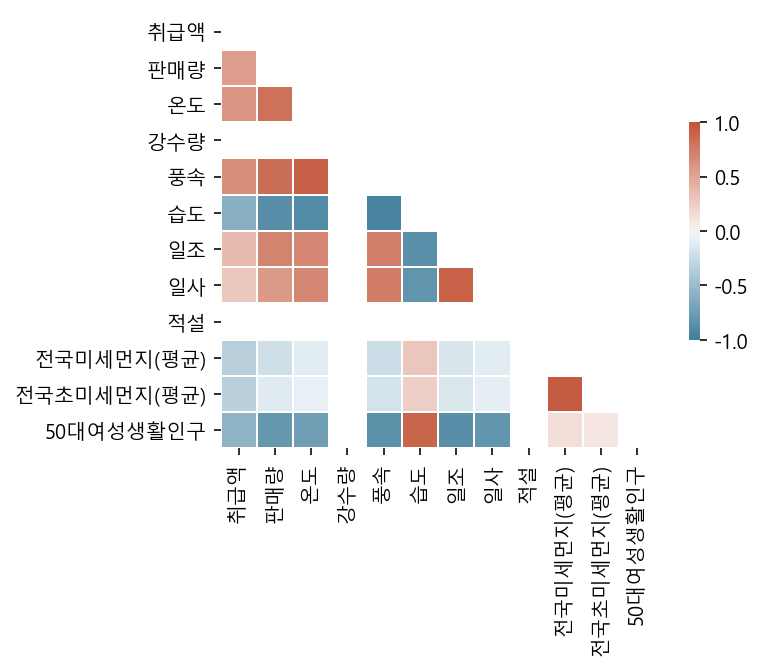


2월 시간대별(0시 ~ 23시) 상관관계 확인


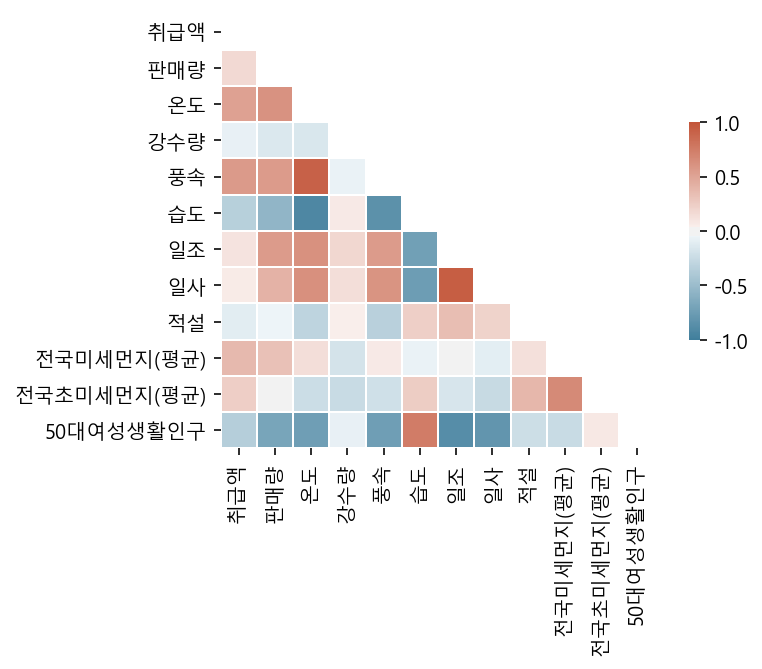


3월 시간대별(0시 ~ 23시) 상관관계 확인


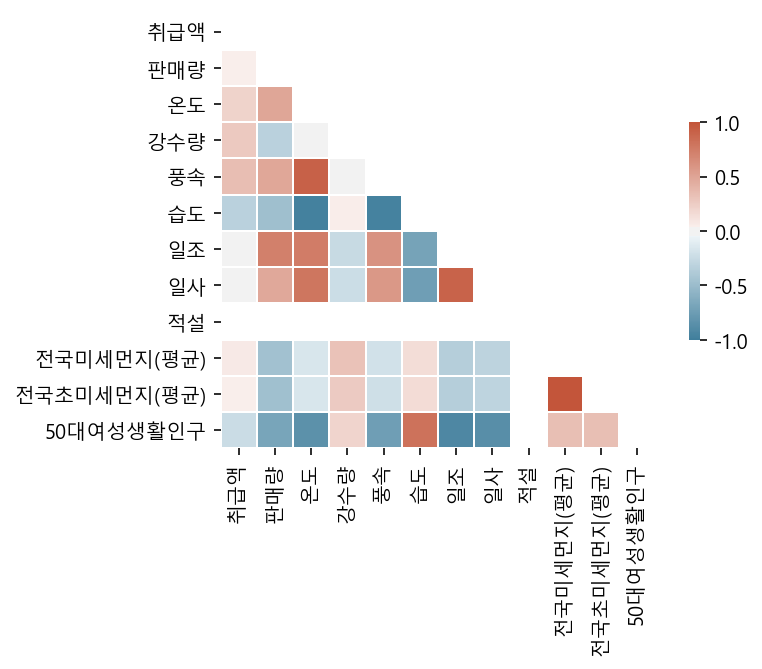


4월 시간대별(0시 ~ 23시) 상관관계 확인


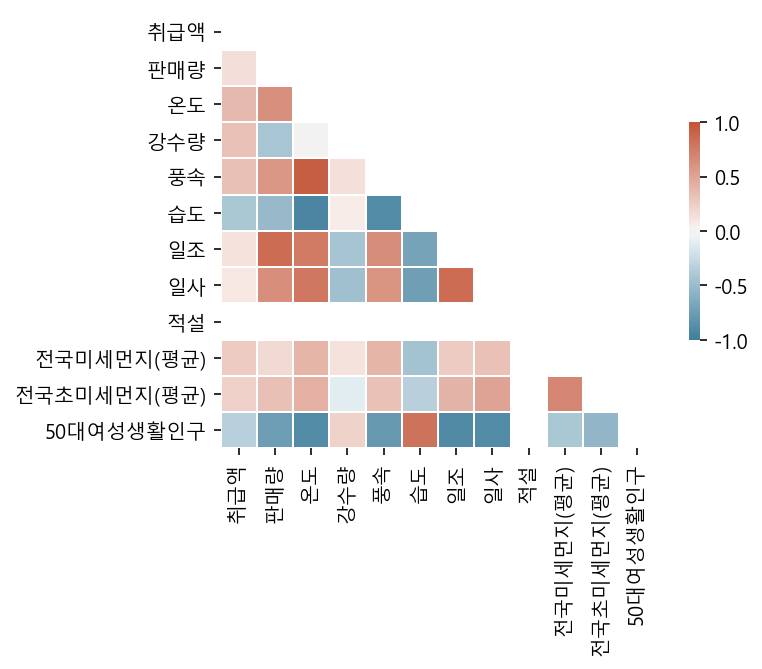


5월 시간대별(0시 ~ 23시) 상관관계 확인


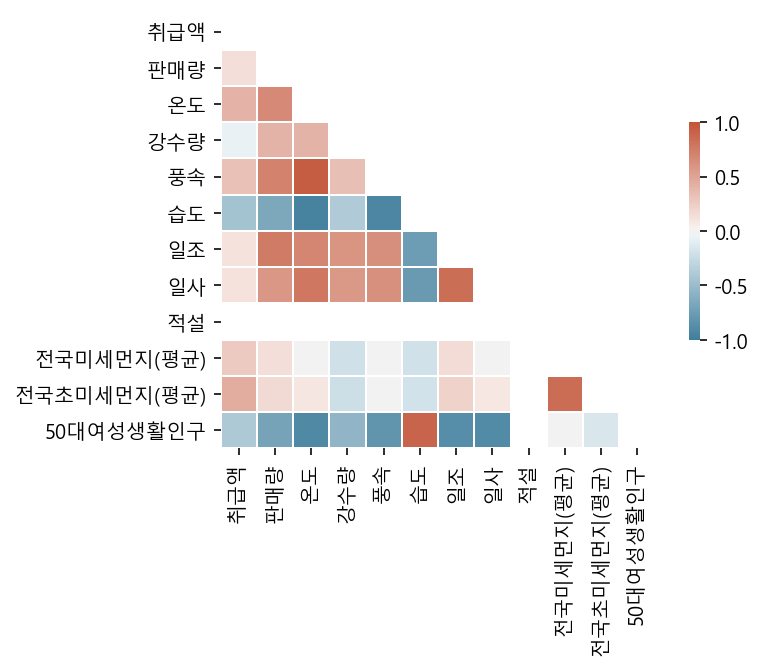


6월 시간대별(0시 ~ 23시) 상관관계 확인


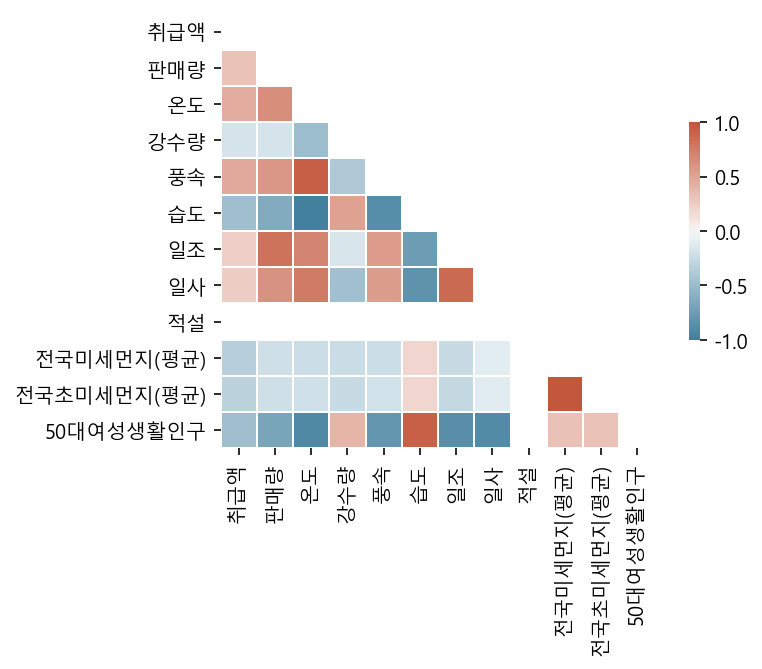


7월 시간대별(0시 ~ 23시) 상관관계 확인


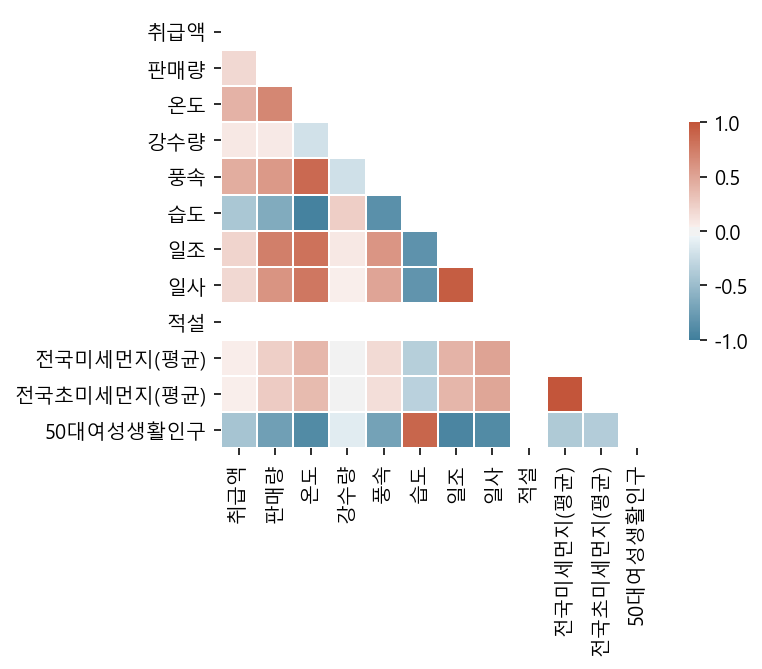


8월 시간대별(0시 ~ 23시) 상관관계 확인


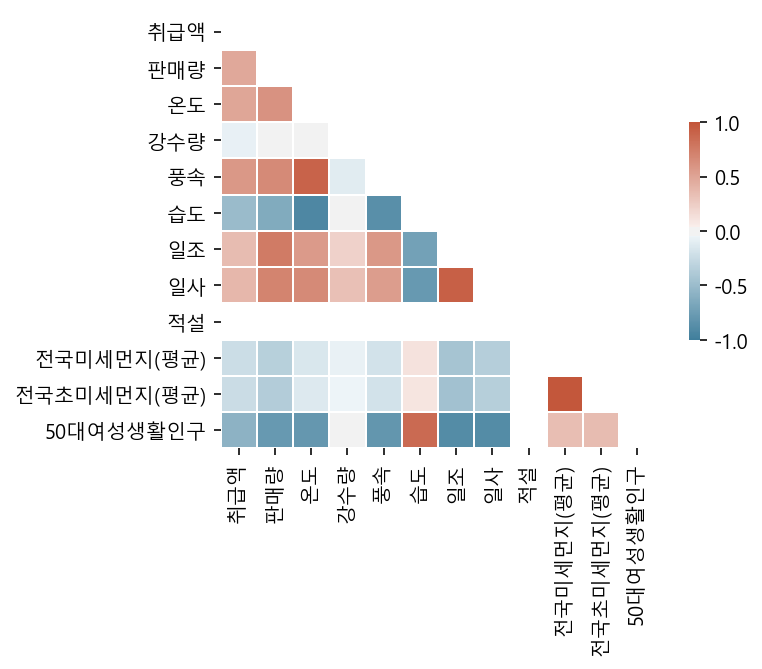


9월 시간대별(0시 ~ 23시) 상관관계 확인


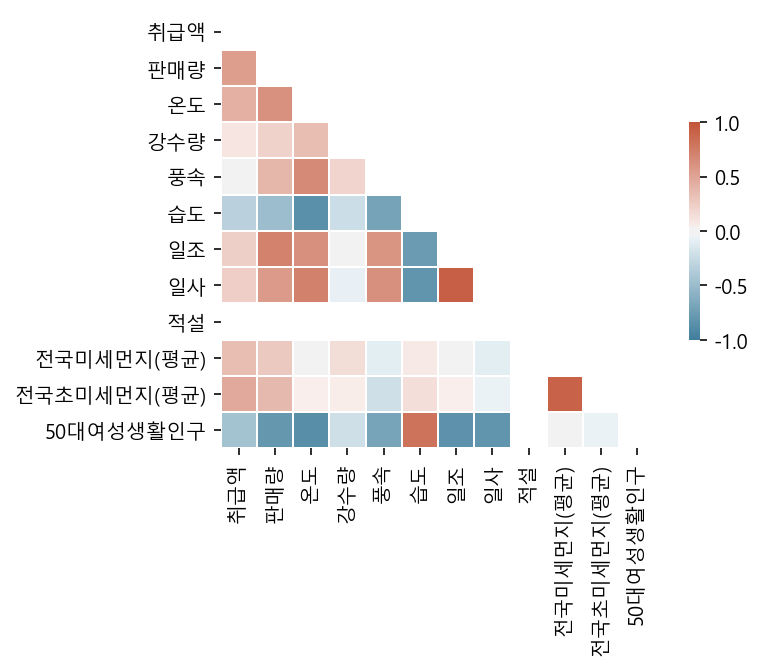


10월 시간대별(0시 ~ 23시) 상관관계 확인


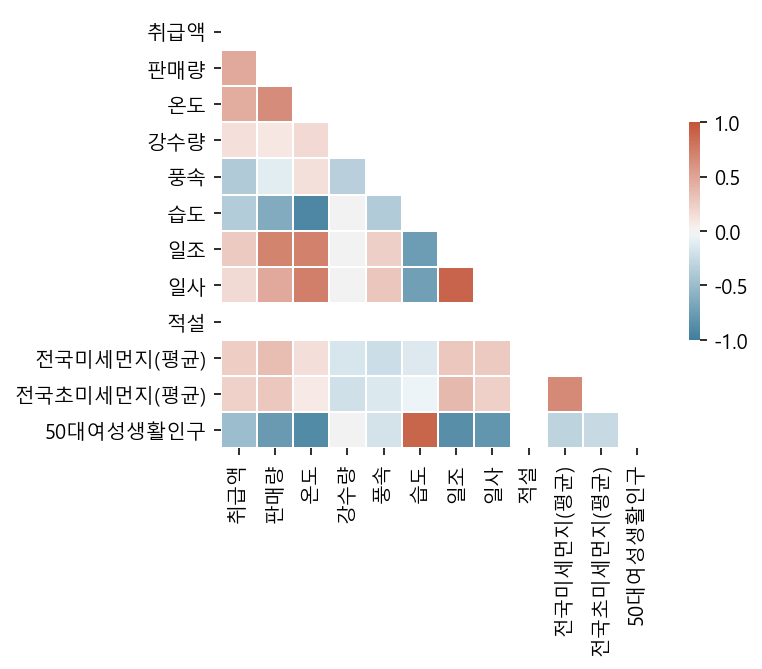


11월 시간대별(0시 ~ 23시) 상관관계 확인


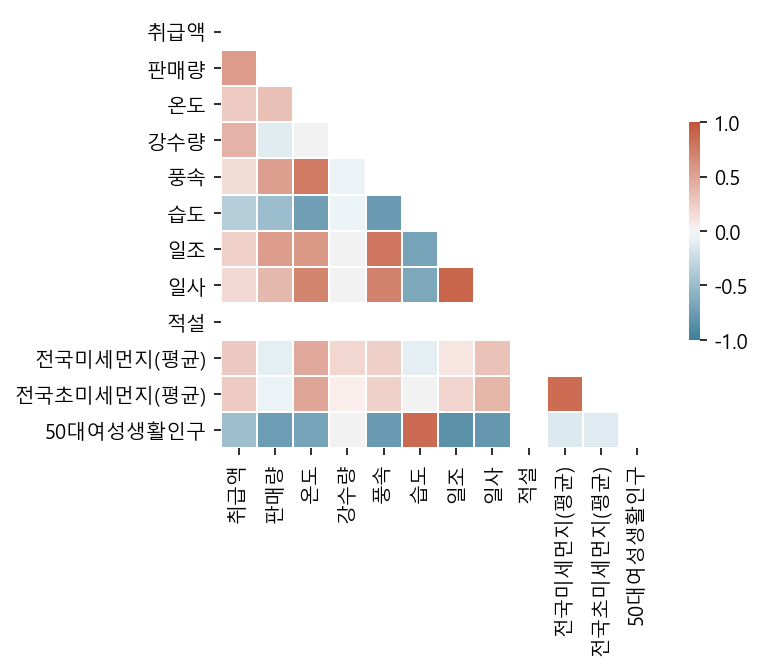


12월 시간대별(0시 ~ 23시) 상관관계 확인


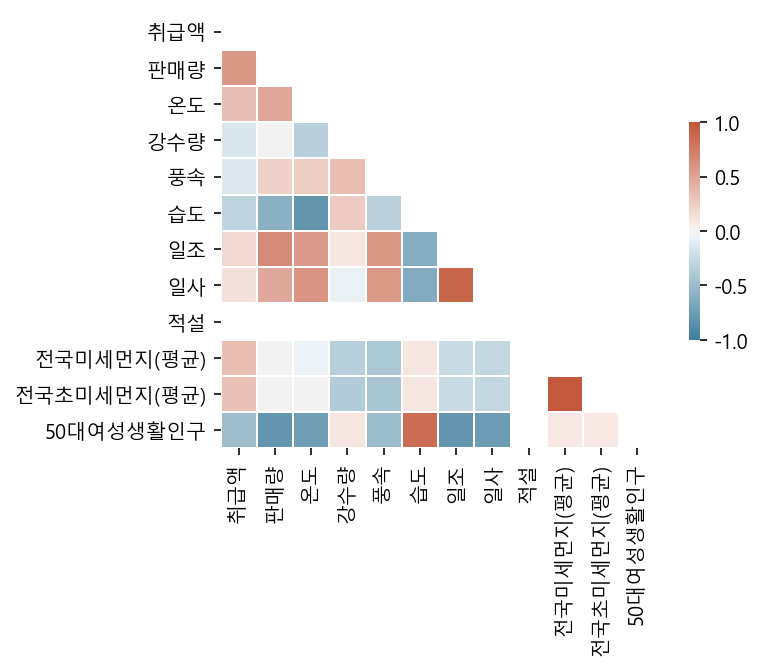

In [12]:
# 각 월별 총 생활인구와 시간대별 feature 상관관계
Y = ['취급액', '판매량']
X = ['온도', '강수량', '풍속', '습도', '일조', '일사', '적설', '전국미세먼지(평균)', '전국초미세먼지(평균)', '50대여성생활인구']

# 각 월별 확인
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for month, df in zip(months, dfs):
    print(f"{month}월 시간대별(0시 ~ 23시) 상관관계 확인")
    check_correlation(df, Y, X)
    print()

## 50대 여성 생활인구수 높은 시간대 확인

 기존 Correlation EDA 결과(총생활인구수와 각 내부, 외부변수 간)와 크게 다르지 않아 보인다. 50대 여성 생활인구수가 높은 시간대를 분석해 보자.
 50대 여성 생활인구수가 많은 시간대 자체는 총 생활인구수와 크게 다르지 않다.

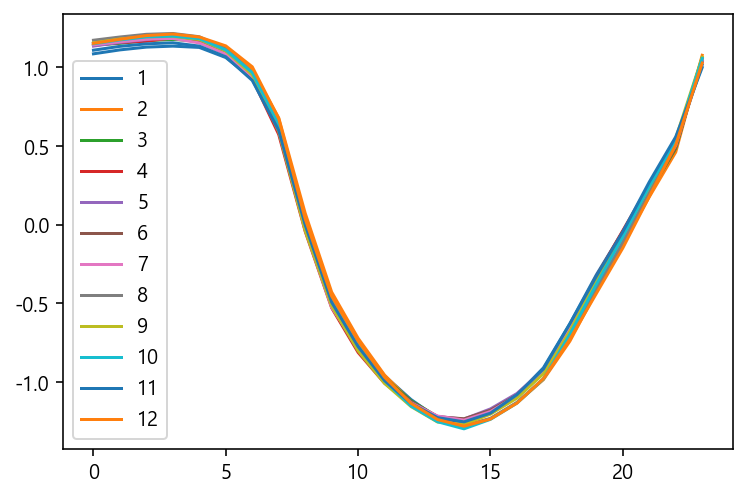

In [13]:
# 그림으로 확인
for col in df_p.columns[1:]:
    plt.plot(df_p['방송시간대'], df_p[col], label=col)
plt.legend()
plt.show()

In [14]:
# 방송시간대 높은 순서대로 확인
df_p['mean'] = df_p[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].mean(axis=1)
df_p = df_p.sort_values(by='mean', ascending=False)
ranks = df_p['방송시간대'].tolist()

In [15]:
# 분석할 feature
df = df_climate[['마더코드', '상품코드', '방송시간대', '상품군', '상품명_통일', '판매단가', '판매량', '취급액', 
                '월', '일', '요일', '온도', '강수량', '풍속', '습도', '일조', '일사', '전국미세먼지(평균)', '전국초미세먼지(평균)',
                '불쾌지수', '불쾌지수단계', '계절']]
df.head(3)

,마더코드,상품코드,방송시간대,상품군,상품명_통일,판매단가,판매량,취급액,월,일,...,강수량,풍속,습도,일조,일사,전국미세먼지(평균),전국초미세먼지(평균),불쾌지수,불쾌지수단계,계절
0,100010,200014,17,농수축,AAB의 소곱창전골,55900,3675.527728,205462000,5,3,...,0.0,2.4,20,1.0,1.66,54.411765,23.588235,68.64000,보통,봄
1,100010,200014,17,농수축,AAB의 소곱창전골,55900,3797.101968,212258000,5,9,...,0.0,3.2,23,1.0,1.77,47.529412,20.647059,66.04794,낮음,봄
2,100010,200014,16,농수축,AAB의 소곱창전골,55900,2134.722719,119331000,5,14,...,0.0,2.8,26,1.0,2.11,49.470588,31.294118,70.65462,보통,봄


시간대: [3, 2, 4, 1, 0, 5]
속옷      236
잡화      232
의류      225
생활용품    163
이미용      80
주방       49
농수축      42
침구       33
가구       29
가전       28
건강기능     26
Name: 상품군, dtype: int64 

낮음      883
보통      163
높음       96
매우높음      1
Name: 불쾌지수단계, dtype: int64 

선일금고  이볼브시리즈            60
가이거  다이아몬드워치            26
  옛날그쥐포                 18
  올바로문어발샤워기             12
가이거 여자 다이아몬드워치          12
                        ..
  거미손차량용공기청정기            1
엘렌실라  코즈미쑥클렌져            1
로베르타디까메리노  로베ROBE토트백     1
로베르타디까메리노  아쿠아마레백팩       1
썸덱스  쉬룰데일리백팩             1
Name: 상품명_통일, Length: 369, dtype: int64 



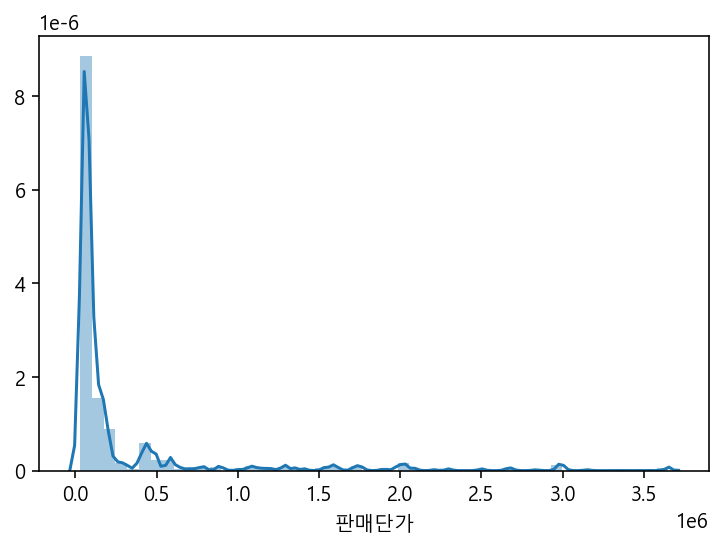

In [16]:
# 첫 번째 그룹
df_p1 = df.loc[df['방송시간대'].isin(ranks[:6])]

print("시간대:", ranks[:6])

# 각 변수 분포
print(df_p1['상품군'].value_counts(), '\n') # 속옷, 잡화, 의류, 생활용품
print(df_p1['불쾌지수단계'].value_counts(), '\n') # 속옷, 잡화, 의류, 생활용품
print(df_p1['상품명_통일'].value_counts(), '\n')
sns.distplot(df_p1['판매단가']) # 50만 원 이하
plt.show()

시간대: [23, 6, 7, 22, 21, 8]
가전      1584
가구       658
의류       517
주방       493
생활용품     441
잡화       395
속옷       387
건강기능     129
이미용      119
농수축       57
침구        24
Name: 상품군, dtype: int64 

낮음      3514
보통       828
높음       423
매우높음      39
Name: 불쾌지수단계, dtype: int64 

LG  울트라HDTV             798
쿠쿠  전기밥솥                180
LG  매직스페이스냉장고           168
보루네오  피올레천연소가죽소파        168
삼성  UHDTV               126
                       ... 
더블유베일 여자 롱코트              1
릴리젼 남자 티셔츠                1
  옛날그쥐포                   1
유리진 여자 코튼블렌딩 실켓티블라우스      1
생쥴랑  14K목걸이               1
Name: 상품명_통일, Length: 687, dtype: int64 



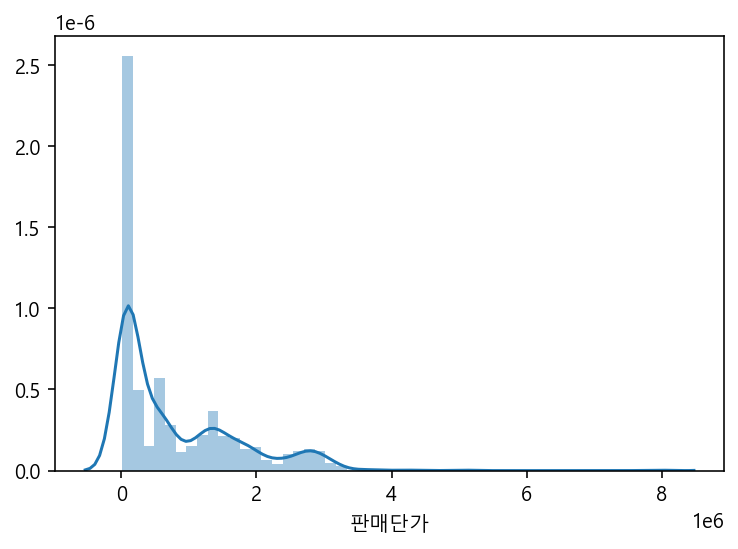

In [17]:
# 두 번째 그룹
df_p2 = df.loc[df['방송시간대'].isin(ranks[6:12])]

print("시간대:", ranks[6:12])

# 각 변수 분포
print(df_p2['상품군'].value_counts(), '\n') 
print(df_p2['불쾌지수단계'].value_counts(), '\n') 
print(df_p2['상품명_통일'].value_counts(), '\n')
sns.distplot(df_p2['판매단가']) 
plt.show()

시간대: [20, 19, 9, 18, 10, 17]
주방      792
농수축     636
잡화      535
속옷      410
가전      398
의류      370
생활용품    254
가구      195
이미용     111
건강기능     51
침구        3
Name: 상품군, dtype: int64 

낮음      2498
보통       770
높음       361
매우높음     126
Name: 불쾌지수단계, dtype: int64 

쿠첸  풀스텐압력밥솥              122
쿠쿠  전기밥솥                 121
쿠첸  압력밥솥                  94
LG  통돌이세탁기                76
LG  울트라HDTV               66
                        ... 
라쉬반 남자 뉴트로 에어 에디션 드로즈      1
히트융 남자 동내의                 1
명인김규흔의  영양강정바              1
완도  꼬마활전복                  1
리복 남자 스피드윅 웜웨어             1
Name: 상품명_통일, Length: 585, dtype: int64 



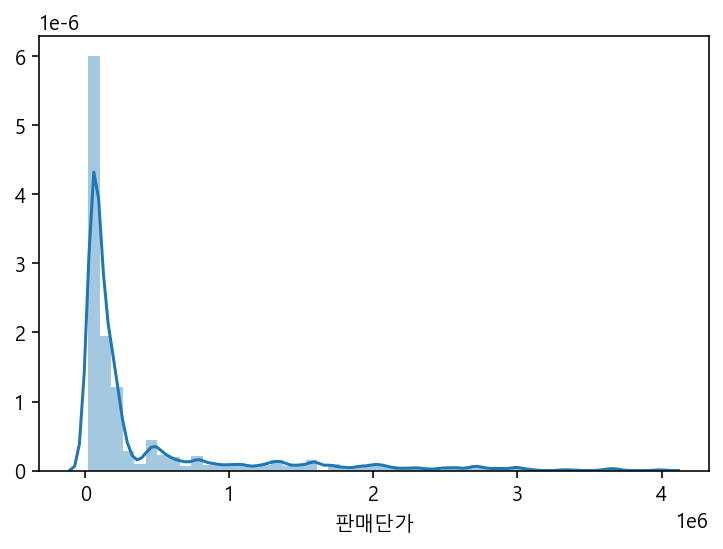

In [18]:
# 세 번째 그룹
df_p3 = df.loc[df['방송시간대'].isin(ranks[12:18])]

print("시간대:", ranks[12:18])

# 각 변수 분포
print(df_p3['상품군'].value_counts(), '\n') 
print(df_p3['불쾌지수단계'].value_counts(), '\n') 
print(df_p3['상품명_통일'].value_counts(), '\n')
sns.distplot(df_p3['판매단가']) 
plt.show()

시간대: [11, 16, 12, 15, 13, 14]
주방      938
잡화      692
농수축     582
의류      346
속옷      313
침구      172
가전      169
생활용품    153
이미용     144
건강기능     65
가구        3
Name: 상품군, dtype: int64 

낮음      2063
보통       803
높음       507
매우높음     204
Name: 불쾌지수단계, dtype: int64 

쿠쿠  전기밥솥               187
한일  스텐분쇄믹서기            106
쿠첸  풀스텐압력밥솥             94
린나이  자동불꽃조절가스레인지        84
비버리힐스  폴로클럽남성기초세트       78
                      ... 
레코바 여자 어반3종              1
  국내산손질병어                1
아가타  겨울부츠1종소프트퍼슈즈1종      1
엘렌실라  달팽이크림콜라겐           1
AAC  한우소머리곰탕양곰탕          1
Name: 상품명_통일, Length: 609, dtype: int64 



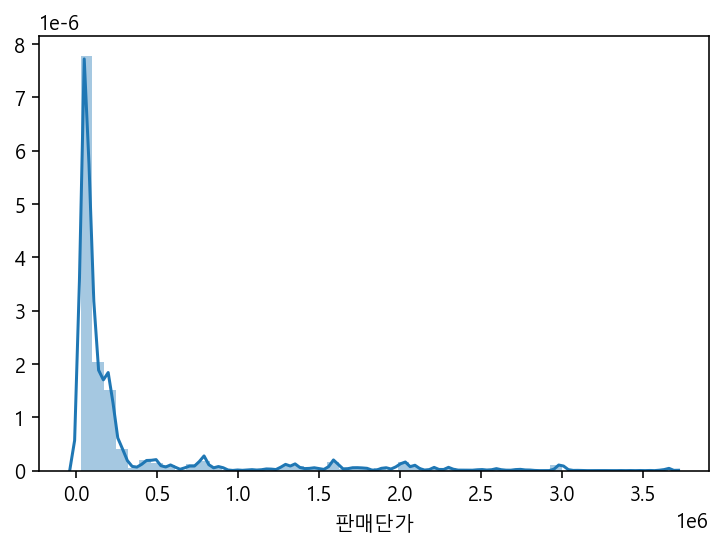

In [19]:
# 네 번째 그룹
df_p4 = df.loc[df['방송시간대'].isin(ranks[18:])]

print("시간대:", ranks[18:])

# 각 변수 분포
print(df_p4['상품군'].value_counts(), '\n') 
print(df_p4['불쾌지수단계'].value_counts(), '\n') 
print(df_p4['상품명_통일'].value_counts(), '\n')
sns.distplot(df_p4['판매단가']) 
plt.show()